# Разведка и обработка данных

In [123]:
# Импортируем необходимое:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

import snowballstemmer

### Ознакомимся с данными

In [6]:
df = pd.read_csv('data/train.tsv', sep="\t")

In [7]:
# Как выглядит датасет?:
df.head(10)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем...,0
9,Microsoft объявила дату выхода очков дополненн...,0


In [8]:
df.tail()

,title,is_fake
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0
5754,Правительство застроит Россию нефтепродуктопро...,0
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1
5756,Туркмения в декабре начнет поставки газа в Китай,0
5757,Бывший тренер Локомотива возглавил нальчикский...,0


In [9]:
# Проверим на наличие пропусков:
df.isna().sum()

title      0
is_fake    0
dtype: int64

In [10]:
# Обьем и типы данных:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


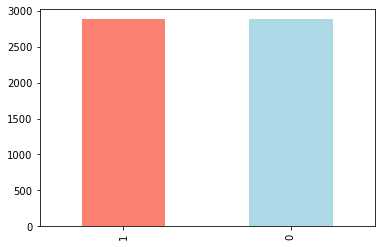

In [11]:
# Распределение меток:
df['is_fake'].value_counts().plot(kind='bar', color=["salmon", "lightblue"]);

Лейблы распределены равномерно (поровну 0 и 1), что очень удобно для тренировки модели.

Длина заголовка, даже при наличии некоторой корреляции, врядли может послужить валидным показателем, т.к. из жизненного опыта мы знаем, что любая новость может иметь заголовок любой длины в рамках принятых с СМИ норм. 

Таким образом, попытка опираться на этот показатель может привести к возрастанию ложно положительных или ложно отрицательных результатов.

Т.к. других полей не предоставлено, можно перейти к построению моделей.

In [12]:
stemmer = snowballstemmer.stemmer('russian')

In [13]:
# Разобъем данные на тренировочный и валидационный наборы.
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['is_fake'], test_size=0.25, random_state=42, shuffle=True)

In [14]:
X_train.shape, y_train.shape, y_test.shape, X_test.shape

((4318,), (4318,), (1440,), (1440,))

### Произведем стемминг

In [15]:
Xs_test = [' '.join(stemmer.stemWords(line.split())) for line in X_test]
Xs_train = [' '.join(stemmer.stemWords(line.split())) for line in X_train]

In [236]:
Xs_test[:3], Xs_train[:3]

(['Учен рад Марс прож восем месяц в изоляц на Гавай',
  'Обзор рынков: РТС не удержа на отметк 1900 пункт',
  'Sony Pictures куп сценар фильма-катастроф Эммерих'],
 ['Начальн класс переведут на учебник арифметик Юри Рыбников',
  'Дэниел Крейг возглав рейтинг сам элегантн британц',
  'В Белорусс ликвидир СМИ, недостаточн освеща сельскохозяйствен работ'])

In [17]:
# Превратим текстовые данные в числовые векторы:
vectorizer = TfidfVectorizer(stop_words=None,
                             ngram_range=(1, 1),
                             lowercase=False)

Для последующего сравнения создадим два варианта набора данных:

In [63]:
# Без стемминга
Xv_train = vectorizer.fit_transform(X_train)
Xv_test = vectorizer.transform(X_test)

# Со стеммингом
Xsv_train = vectorizer.fit_transform(Xs_train)
Xsv_test = vectorizer.transform(Xs_test)

In [23]:
Xv_test.shape, Xv_train.shape

((1440, 11075), (4318, 11075))

In [64]:
Xsv_test.shape, Xsv_train.shape

((1440, 11075), (4318, 11075))

# Построим модели

Напишем функцию, прогоняющую данные через все модели, сравнивая их эффективность:

In [65]:
models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Random Forest': RandomForestClassifier(),
          'SVC': SVC()}

# Функция для тртенировки и оценки моделей
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Тренирует и оценивает заданные модели.
    models : словарь из моделей Scikit-Learn
    X_train : тренировочные данные (no labels)
    X_test : проверочные данные (no labels)
    y_train : тренировочные лейблы
    y_test : проверочные лейблы
    """
    np.random.seed(42)
    # Словарь для хранения результативности моделей
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [66]:
# Вариант без стемминга:
model_scores = fit_and_score(models=models, 
                             X_train=Xv_train, 
                             X_test=Xv_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Logistic Regression': 0.8256944444444444,
 'KNN': 0.7743055555555556,
 'Random Forest': 0.7104166666666667,
 'SVC': 0.8263888888888888}

In [68]:
# Вариант со стеммингом:
model_scores_s = fit_and_score(models=models, 
                               X_train=Xsv_train, 
                               X_test=Xsv_test,
                               y_train=y_train,
                               y_test=y_test)
model_scores_s

{'Logistic Regression': 0.8375,
 'KNN': 0.7875,
 'Random Forest': 0.7409722222222223,
 'SVC': 0.8444444444444444}

В обоих случаях `Logistic Regression` и `SVC` показали наилучшие результаты "из коробки".

Попробуем донастроить лучшие модели.

### Настройка гиперпараметров

#### Настроим LogisticRegression

In [26]:
# Зададим сетку параметров:
logreg_grid = {"C": np.logspace(-4, 4, 20),
           "solver": ["liblinear", "newton-cg"]}

In [72]:
# Без стемминга
np.random.seed(42)

# Настраиваем перебор параметров по сетке для LogisticRegression
rs_logreg = GridSearchCV(LogisticRegression(),
                         param_grid=logreg_grid,
                         cv=5,
                         verbose=True)

# Тренируем LogisticRegression
rs_logreg.fit(Xv_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear', 'newton-cg']},
             verbose=True)

In [73]:
# Состеммингом:
np.random.seed(42)

# Настраиваем перебор параметров по сетке для LogisticRegression
rs_logreg_s = GridSearchCV(LogisticRegression(),
                           param_grid=logreg_grid,
                           cv=5,
                           verbose=True)

# Тренируем LogisticRegression
rs_logreg_s.fit(Xsv_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear', 'newton-cg']},
             verbose=True)

In [74]:
# Оптимальный набор параметров для Logistic Regression:
rs_logreg.best_params_, rs_logreg_s.best_params_

({'C': 206.913808111479, 'solver': 'liblinear'},
 {'C': 78.47599703514607, 'solver': 'liblinear'})

In [76]:
y_preds = rs_logreg.predict(Xv_test)
y_preds_s = rs_logreg_s.predict(Xsv_test)

In [77]:
# Посмотрим на показатели модели без применения стемминга
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       701
           1       0.83      0.85      0.84       739

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



In [78]:
# ...и со стеммингом
print(classification_report(y_test, y_preds_s))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       701
           1       0.84      0.84      0.84       739

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



In [237]:
pd.crosstab(y_test, y_preds)

col_0,0,1
is_fake,,
0,575,126
1,108,631


In [238]:
pd.crosstab(y_test, y_preds_s)

col_0,0,1
is_fake,,
0,582,119
1,116,623


In [82]:
y_test.shape

(1440,)

Для данной модели мы получили меньше ложноположительных результатов, по сравнению с ложноотрицательными.
Модель чаще ошибается, принимая фейки за реальные новости.



**`Предлагаемая метрика для оценки f1_score для Logistic Regression:`**

In [239]:
LR_f1 = f1_score(y_test, y_preds)
LR_f1_s = f1_score(y_test, y_preds_s)
print(f"LR_f1 = {LR_f1}")
print(f"LR_f1_s = {LR_f1_s}")

LR_f1 = 0.8435828877005348
LR_f1_s = 0.8413234301147874


Показатель f1 немного лучше у варианта без стемминга.



#### Настроим SVC

In [107]:
# Зададим сетку параметров:
SVC_grid = {"C": np.logspace(0, 100, 10),
            "gamma": ["auto", "scale"],
            "kernel": ["linear", "poly", "rbf", "sigmoid"]}

In [108]:
np.random.seed(42)

# Настраиваем случайный поиск параметров для SVC
rs_SVC = RandomizedSearchCV(SVC(),
                            param_distributions=SVC_grid,
                            cv=5,
                            n_iter=50,
                            verbose=True)

# Тренируем LogisticRegression
rs_SVC.fit(Xv_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50,
                   param_distributions={'C': array([1.00000000e+000, 1.29154967e+011, 1.66810054e+022, 2.15443469e+033,
       2.78255940e+044, 3.59381366e+055, 4.64158883e+066, 5.99484250e+077,
       7.74263683e+088, 1.00000000e+100]),
                                        'gamma': ['auto', 'scale'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   verbose=True)

In [109]:
# Со стеммингом
np.random.seed(42)

# Настраиваем случайный поиск параметров для SVC
rs_SVC_s = RandomizedSearchCV(SVC(),
                              param_distributions=SVC_grid,
                              cv=5,
                              n_iter=50,
                              verbose=True)

# Тренируем LogisticRegression
rs_SVC_s.fit(Xsv_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50,
                   param_distributions={'C': array([1.00000000e+000, 1.29154967e+011, 1.66810054e+022, 2.15443469e+033,
       2.78255940e+044, 3.59381366e+055, 4.64158883e+066, 5.99484250e+077,
       7.74263683e+088, 1.00000000e+100]),
                                        'gamma': ['auto', 'scale'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   verbose=True)

In [111]:
# Оптимальный набор параметров для SVC:
rs_SVC.best_params_, rs_SVC_s.best_params_

({'kernel': 'linear', 'gamma': 'auto', 'C': 1.0},
 {'kernel': 'poly', 'gamma': 'auto', 'C': 4.641588833612677e+66})

In [112]:
y_preds1 = rs_SVC.predict(Xv_test)
y_preds1_s = rs_SVC_s.predict(Xsv_test)

In [113]:
print(classification_report(y_test, y_preds1))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       701
           1       0.84      0.85      0.84       739

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



In [114]:
print(classification_report(y_test, y_preds1_s))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       701
           1       0.86      0.83      0.85       739

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.85      0.84      0.84      1440



In [115]:
pd.crosstab(y_test, y_preds1)

col_0,0,1
is_fake,,
0,580,121
1,113,626


In [116]:
pd.crosstab(y_test, y_preds1_s)

col_0,0,1
is_fake,,
0,602,99
1,125,614


`SVC` со стеммингом дала немного меньше ложноотрицательных результатов по сравнению с `LogisticRegression`, но в среднем больше ложноположительных. 

Не смотря на более низкий показатель f1, в зависимости от специфики задачи, `SVC` может дать более качественный результат, например, **если важно детектировать именно фейки**.

**`Предлагаемая метрика для оценки f1_score для SVC:`**

In [240]:
SVC_f1 = f1_score(y_test, y_preds1)
SVC_f1_s = f1_score(y_test, y_preds1_s)
print(f"SVC_f1 = {SVC_f1}")
print(f"SVC_f1_s = {SVC_f1_s}")

SVC_f1 = 0.8425302826379543
SVC_f1_s = 0.8457300275482094


Для `SVC` показатель `f1` выше при использовании стемминга



#### Настроим KNN

In [95]:
# Сетка параметров:
KNN_grid = {"n_neighbors": range(1, 21),
            "weights": ["uniform", "distance"]}

In [96]:
np.random.seed(42)

# Настраиваем сеточный поиск параметров для KNN
rs_KNN = GridSearchCV(KNeighborsClassifier(),
                      param_grid=KNN_grid,
                      cv=5,
                      verbose=True)

# Тренируем LogisticRegression
rs_KNN.fit(Xv_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21),
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [97]:
np.random.seed(42)

# Настраиваем сеточный поиск параметров для KNN
rs_KNN_s = GridSearchCV(KNeighborsClassifier(),
                        param_grid=KNN_grid,
                        cv=5,
                        verbose=True)

# Тренируем LogisticRegression
rs_KNN_s.fit(Xsv_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21),
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [98]:
# Оптимальный набор параметров для KNN:
rs_KNN.best_params_, rs_KNN_s.best_params_

({'n_neighbors': 4, 'weights': 'distance'},
 {'n_neighbors': 6, 'weights': 'distance'})

In [100]:
y_preds2 = rs_KNN.predict(Xv_test)
y_preds2_s = rs_KNN_s.predict(Xsv_test)

In [101]:
print(classification_report(y_test, y_preds2))

              precision    recall  f1-score   support

           0       0.75      0.83      0.78       701
           1       0.82      0.73      0.77       739

    accuracy                           0.78      1440
   macro avg       0.78      0.78      0.78      1440
weighted avg       0.78      0.78      0.78      1440



In [102]:
print(classification_report(y_test, y_preds2_s))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       701
           1       0.86      0.73      0.79       739

    accuracy                           0.80      1440
   macro avg       0.81      0.80      0.80      1440
weighted avg       0.81      0.80      0.80      1440



In [103]:
pd.crosstab(y_test, y_preds2)

col_0,0,1
is_fake,,
0,580,121
1,198,541


In [104]:
pd.crosstab(y_test, y_preds2_s)

col_0,0,1
is_fake,,
0,613,88
1,198,541


В отличии от предыдущих моделей, у `KNN` можно наблюдать преобладание ошибок ложноположительного типа и слабый `f1`.

Однако, данная модель при использовании стемминга показала наивысший `recall` для is_fake=0. Другими словами, данная модель лучше всех показала себя в определении фальшивости новостей, хотя она чаще других принимает истинные новости за фальшивые.

**`Предлагаемая метрика для оценки f1_score для KNN:`**

In [241]:
KNN_f1 = f1_score(y_test, y_preds2)
KNN_f1_s = f1_score(y_test, y_preds2_s)
print(f"KNN_f1 = {KNN_f1}")
print(f"KNN_f1_s = {KNN_f1_s}")

KNN_f1 = 0.7723054960742327
KNN_f1_s = 0.79093567251462


Модель лучше показалла себя со стеммингом

### Сравними показатели лучших моделей

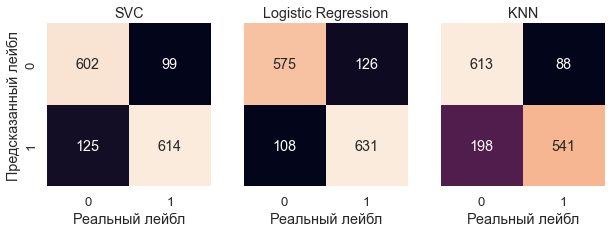

f1 для SVC (stem): 	0.8457300275482094
f1 для LogReg: 		0.8435828877005348
f1 для KNN (stem): 	0.79093567251462


In [246]:
# Выведем свобную таблицы скоров и кросстабы самых интеерсных вариантов на одном графике:

sns.set(font_scale=1.2)

fig, (ax0, ax1, ax2) = plt.subplots(sharey=True, nrows=1, ncols=3, figsize=(10, 3))

ax0 = sns.heatmap(confusion_matrix(y_test, y_preds1_s),
                  ax = ax0,
                  annot=True,
                  cbar=False, fmt='.0f')
ax0.set(title='SVC',
        xlabel="Реальный лейбл",
        ylabel="Предсказанный лейбл")

ax1 = sns.heatmap(confusion_matrix(y_test, y_preds),
                  ax = ax1,
                  annot=True,
                  cbar=False,
                  fmt='.0f')
ax1.set(title='Logistic Regression',
        xlabel="Реальный лейбл")

ax2 = sns.heatmap(confusion_matrix(y_test, y_preds2_s),
                  ax = ax2,
                  annot=True,
                  cbar=False,
                  fmt='.0f')
ax2.set(title='KNN',
        xlabel="Реальный лейбл")

plt.show()

print(f'f1 для SVC (stem): \t{SVC_f1_s}')
print(f'f1 для LogReg: \t\t{LR_f1}')
print(f'f1 для KNN (stem): \t{KNN_f1_s}')


Опираясь на сравнение по метрике **f1**, лучше всех показала себя модель **`SVC`** с показателем **0.85**

**Замечание:** Не смотря на самый низкий f1 из представленных, для определенного круга задач (требующий обнаружения максимального количества фейков) лучше подойдет модель `KNN`.

В тоже время `Logistic Regression` при сравнимом f1 показал лучщие результаты для обнаружения реальных новостей, что может дать лучший эффект для другого рода задач.


# Сделаем предсказания на тестовом датасете

In [214]:
# Импортируем датасет
test_df = pd.read_csv('data/test.tsv', sep="\t")
test_df

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,0
996,В День Победы стратегические ракетоносцы Ту-16...,0
997,СК возбудил дело против авиакомпании «Победа» ...,0
998,Криптомонетный двор Туркменистана выпустил юби...,0


In [215]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [216]:
# Экстрагируем данные в переменную
X_ctrl = test_df['title']
X_ctrl

0      Роскомнадзор представил реестр сочетаний цвето...
1      Ночью под Минском на президентской горе Белара...
2      Бывший спичрайтер Юрия Лозы рассказал о трудно...
3      Сельская церковь, собравшая рекордно низкое ко...
4      Акции Google рухнули после объявления о переза...
                             ...                        
995    Прокуратура заподозрила Явлинского в авторитар...
996    В День Победы стратегические ракетоносцы Ту-16...
997    СК возбудил дело против авиакомпании «Победа» ...
998    Криптомонетный двор Туркменистана выпустил юби...
999    Deutsche Bahn заплатит рекордный штраф за чтен...
Name: title, Length: 1000, dtype: object

In [217]:
# Сделаем стемминг
Xs_ctrl = [' '.join(stemmer.stemWords(line.split())) for line in X_ctrl]

In [222]:
# Переведем в векторы
Xv_ctrl = vectorizer.transform(Xs_ctrl)

In [223]:
Xv_ctrl.shape

(1000, 11075)

#### Выполним предсказания

Для предсказаний используем `SVC` - модель, показавшую наилучший результат на тренировке.


*Данная модель выбрана т.к. имеет наивысший* ***f1_sсore***, *согласно постановке задачи.*

In [225]:
y_ctrl = rs_SVC_s.predict(Xv_ctrl)

In [234]:
y_ctrl.shape, y_ctrl[:20]

((1000,), array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]))

#### Упакуем предсказания в датасет и сохраним

In [227]:
test_df['is_fake'] = y_ctrl

In [228]:
test_df

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,1
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


In [229]:
# Сохраним в файл:
test_df.to_csv('./predictions.tsv', sep='\t', index=False)

Проверим успешность сохранения:

In [230]:
check = pd.read_csv('./predictions.tsv', sep='\t')
check

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,1
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


In [231]:
# Сравним с сохраняемым датасетом:
test_df

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,1
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


Сохранение прошло успешно 👍

### Задача выполнена

#### Гипотезы по улучшению качества предсказаний:

* В первую очередь увеличить размер тренировочного датасета
* Использовать метод Transfer Learning с использованием слоя, натренированного на аналогичные задачи
* Использовать векторизатор, адаптированный для русского языка, либо русскоязычный набор стоп слов с текущим векторизатором
* Провести эксперименты с другими моделями (в ходе экспериментов я так же использовал Keras, но он дал показатели ниже моделей, представленных в текущем блокноте)